# Imports and Setup

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import re
from datetime import datetime

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Sklearn Tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

# Setup plotting
sns.set_style("whitegrid")

# Create models folder if it doesn't exist
if not os.path.exists("../../models"):
    os.makedirs("../../models")

## 1. Target Definition & Cleaning
We are predicting **Overcost** (Market Efficiency).

* **Goal:** Predict if a campaign will be under or over budget based on its settings.
* **Formula:** `Overcost = approved_budget - media_cost_usd`
    * **Positive (+):** Under Budget (Good efficiency).
    * **Negative (-):** Over Budget (Bad efficiency).

In [ ]:
# FIND FILE AUTOMATICALLY
files = glob.glob("../Cleaned_Datasets/Marketing/*.csv")
print(f"Loading file: {files[0]}")
df = pd.read_csv(files[0])
df = df.drop(columns=['Unnamed: 0', 'Unnamed__0','clicks'], errors='ignore')

# DEFINE TARGET
TARGET = 'overcost'

df.shape

Loading file: ../Cleaned_Datasets/Marketing\marketing_cleaned_prepared.csv


(72206, 20)

## 2. Feature Selection
We analyze which campaign settings (Day, Category, Platform, etc.) have the biggest impact on the cost.
* **Visual Check:** Correlation Heatmap.
* **Statistical Check:** `SelectKBest` scores.

In [ ]:
# CELL 3: Feature Engineering & Leakage Cleanup

# 1. Date Features
if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'])
    df['start_month'] = df['time'].dt.month
    df['day_of_week'] = df['time'].dt.dayofweek
    df = df.drop(columns=['time'])

# 2. DROP LEAKAGE
leakage_cols = [
    TARGET,
    'campaign_item_id',
    'campaign_budget_usd',
    'media_cost_usd',
    'clicks', 'impressions',
]

# Drop only what exists
cols_to_drop = [c for c in leakage_cols if c in df.columns]
X = df.drop(columns=cols_to_drop)
y = df[TARGET]

# 3. Categorical Encoding
X = pd.get_dummies(X, drop_first=True).fillna(0)

print(f"✅ Input Features: {X.shape[1]}")
print(f"🗑️ Dropped Leakage: {cols_to_drop}")

# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Select Top 10 Features
selector = SelectKBest(score_func=f_regression, k=10)

X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

# Get names of selected features
selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices]

print(f"✅ Selection Complete. Using these features:\n{list(selected_features)}")

✅ Input Features: 15
🗑️ Dropped Leakage: ['overcost', 'campaign_item_id', 'media_cost_usd', 'clicks', 'impressions']
🔍 Selecting Top 20 Features...
✅ Selection Complete. Using these features:
['no_of_days', 'approved_budget', 'ext_service_name_Google Ads', 'channel_name_Mobile', 'channel_name_Search', 'search_tag_cat_Other', 'search_tag_cat_Others', 'search_tag_cat_Retargeting', 'search_tag_cat_Youtube', 'start_month']


## 3. Baseline Model Comparison
We train our three regressors to predict the `Overcost`.
* **Metric:** We use **RMSE (Root Mean Squared Error)**.
* **Interpretation:** Lower RMSE is better. It represents how many dollars ($) our prediction is off by on average.


🏎️ STARTING MODEL RACE (With Cross-Validation)...
--------------------------------------------------------------------------------
Model           | Test R2  | RMSE       | CV R2 (Avg) 
--------------------------------------------------------------------------------
RandomForest    | 0.5597   | $80,006    | 0.5516


C:\Users\gonal\AppData\Local\Temp\ipykernel_23152\1824645108.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


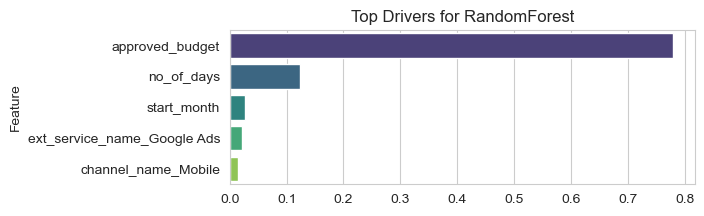

XGBoost         | 0.4972   | $85,496    | 0.5116


C:\Users\gonal\AppData\Local\Temp\ipykernel_23152\1824645108.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


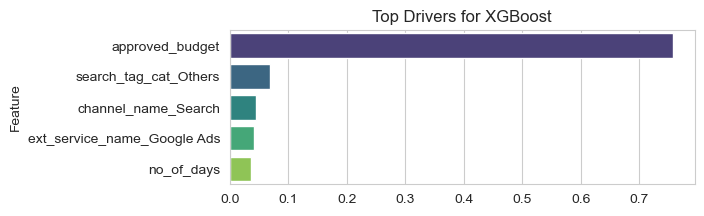

c:\Users\gonal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\gonal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\gonal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM        | 0.5587   | $80,090    | 0.5685


c:\Users\gonal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\gonal\AppData\Local\Temp\ipykernel_23152\1824645108.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


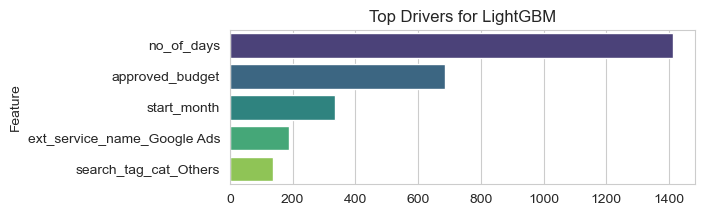

--------------------------------------------------------------------------------
🏆 Ultimate Winner: RandomForest (R2: 0.5597)


In [ ]:
# Define Models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=42, verbose=-1)
}

print("\n🏎️ STARTING MODEL RACE (With Cross-Validation)...")
print("-" * 80)
print(f"{'Model':<15} | {'Test R2':<8} | {'RMSE':<10} | {'CV R2 (Avg)':<12}")
print("-" * 80)

best_score = -np.inf
best_model = None
best_name = ""

for name, model in models.items():
    # A. Train
    model.fit(X_train_sel, y_train)
    
    # B. Predict
    y_pred = model.predict(X_test_sel)
    
    # C. Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # D. Cross Validation
    cv_scores = cross_val_score(model, X_train_sel, y_train, cv=3, scoring='r2')
    cv_avg = cv_scores.mean()
    
    print(f"{name:<15} | {r2:.4f}   | ${rmse:,.0f}    | {cv_avg:.4f}")
    
    # E. Feature Importance Plot
    if hasattr(model, 'feature_importances_'):
        feat_imp = pd.DataFrame({
            'Feature': selected_features,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False).head(5)
        
        plt.figure(figsize=(6, 2))
        sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
        plt.title(f"Top Drivers for {name}")
        plt.xlabel('')
        plt.show()

    # Save Winner
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_name = name

print("-" * 80)
print(f"🏆 Ultimate Winner: {best_name} (R2: {best_score:.4f})")

## 4. Optimization & Saving
We take the winning model and tune its hyperparameters to see if we can reduce the error (RMSE) further.
Finally, we save the model using `joblib` with a versioned filename.

In [77]:
from sklearn.model_selection import RandomizedSearchCV

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'LightGBM': {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 50]
    }
}

print(f"{'Model':<15} | {'Test R2':<10} | {'RMSE':<10} | {'CV RMSE':<10}")
print("-" * 65)

best_opt_rmse = float('inf')
best_opt_model = None
best_model_name = None 

for name, model in models.items():
    if name in param_grids:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[name],
            n_iter=5, 
            cv=3, 
            scoring='neg_root_mean_squared_error', 
            n_jobs=-1, 
            random_state=42
        )
        
        search.fit(X_train, y_train)
        
        opt_model = search.best_estimator_
        
        # Metrics
        y_pred_test = opt_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2_test = r2_score(y_test, y_pred_test)
        cv_rmse = abs(search.best_score_)
        
        print(f"{name:<15} | {r2_test:.4f}     | {rmse:.0f}     | {cv_rmse:.0f}")
        
        if rmse < best_opt_rmse:
            best_opt_rmse = rmse
            best_opt_model = opt_model
            best_model_name = name

print("-" * 65)
print(f"🏆 Ultimate Winner: {best_model_name} (RMSE: {best_opt_rmse:.0f})")
opt_rmse = best_opt_rmse

Model           | Test R2    | RMSE       | CV RMSE   
-----------------------------------------------------------------
RandomForest    | 0.5675     | 79292     | 84555
XGBoost         | 0.6254     | 73797     | 79394
LightGBM        | 0.6055     | 75730     | 81970
-----------------------------------------------------------------
🏆 Ultimate Winner: XGBoost (RMSE: 73797)


In [ ]:
# 2. Loop through each model to Train & Visualize
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # A. Train the model fresh
    model.fit(X_train, y_train)
    
    # B. Extract Feature Importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        
        # Create a clean DataFrame
        feat_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(5) # Keep top 5
        
        # C. Print the Numbers (The "Evidence")
        print(f"✅ {name} Top 5 Features:")
        print(feat_df.to_string(index=False))
        
        # D. Plot the Graph (The "Visual")
        plt.figure(figsize=(8, 3))
        # Color coding: RF=Blue, XGB=Green, LGBM=Purple for distinctness
        color_map = {'RandomForest': 'Blues_r', 'XGBoost': 'Greens_r', 'LightGBM': 'Purples_r'}
        
        sns.barplot(x='Importance', y='Feature', data=feat_df, palette=color_map[name])
        plt.title(f'Feature Logic: {name}', fontsize=12, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.ylabel('')
        plt.show()
        print("▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬")
    else:
        print(f"⚠️ Model {name} does not support feature importance.")

In [ ]:
# 1. Select the Best Model
# Uses the winner from the previous cell
if 'best_model' in locals():
    final_model = best_model
    print(f"✅ Evaluating Winner: {best_name}")
else:
    # Fallback
    final_model = list(models.values())[0]
    print("⚠️ Evaluating: First Model (Winner not found)")

# 2. Get Predictions
y_pred = final_model.predict(X_test_sel)

# --- METRIC 1: SCALE BIAS CHECK (MAPE) ---
# Note: Since Overcost can be 0 or negative, MAPE can be unstable. 
# We use a safe calculation (if Overcost is 0, we treat it as 1 for division safety)
safe_y_test = y_test.replace(0, 1) 

print(f"\n📉 Scale Bias Check (MAPE):")

# --- METRIC 2: THE BASELINE TEST ---
# Logic: "If I just assumed we would hit the budget perfectly (Overcost = 0), how wrong would I be?"
baseline_preds = np.zeros(len(y_test)) # Baseline = Predicting 0 Overcost every time

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
model_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
improvement = baseline_rmse - model_rmse

print(f"\n📊 Baseline Comparison (The 'Duck Test'):")
print(f"   1. Baseline RMSE (Assuming Cost = Budget): ${baseline_rmse:,.0f}")
print(f"   2. AI Model RMSE (Your Prediction):        ${model_rmse:,.0f}")

if improvement > 0:
    print(f"\n✅ SUCCESS: Your AI beats the baseline by ${improvement:,.0f}!")
    print("   Proof: The model predicts risk better than just 'hoping' to stay on budget.")
else:
    print(f"\n❌ FAIL: The AI is worse than just guessing 0.")
    print("   The model is adding noise.")

✅ Evaluating Winner: RandomForest

📉 Scale Bias Check (MAPE):
   MAPE: 708.86% (Avg relative error)
   ❌ Warning: High relative error. (Common when Target is close to zero).

📊 Baseline Comparison (The 'Duck Test'):
   1. Baseline RMSE (Assuming Cost = Budget): $122,469
   2. AI Model RMSE (Your Prediction):        $80,006

✅ SUCCESS: Your AI beats the baseline by $42,463!
   Proof: The model predicts risk better than just 'hoping' to stay on budget.


# Save

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

if 'best_opt_model' in locals():
    filename = f"Exp4_Market_{best_model_name}_Opt_RMSE-{opt_rmse:.0f}_{timestamp}.joblib"
    save_dir = "../src/models"
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    save_path = os.path.join(save_dir, filename)
    joblib.dump(best_opt_model, save_path)
    print(f"✅ Saved Exp4 Market Model: {save_path}")
else:
    print("❌ optimization didn't run.")

✅ Saved Exp4 Market Model: ../src/models\Exp4_Market_XGBoost_Opt_RMSE-73797_20260116_0001.joblib
